# Numpy часть

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RNG = np.random.default_rng(seed=42)

## 1) Загрузка, представление и объём данных

In [148]:
df = pd.read_csv('Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [149]:
X = df.iloc[:, :4].to_numpy()
y = df['Species'].to_numpy()

print("X:", X.nbytes, "bytes")
print("y:", y.nbytes, "bytes")

X: 4800 bytes
y: 1200 bytes


## 2) Нормализация данных в диапазон [0, 1] по колонкам

In [150]:
X_min = X.min(axis=0)
X_max = X.max(axis=0)
range_ = X_max - X_min
range_[range_ == 0] = 1.0  # защита от деления на 0
X_norm = (X - X_min) / range_

print('Пример нормализованных значений:')
print(X_norm[:5])

Пример нормализованных значений:
[[0.         0.22222222 0.625      0.06779661]
 [0.00671141 0.16666667 0.41666667 0.06779661]
 [0.01342282 0.11111111 0.5        0.05084746]
 [0.02013423 0.08333333 0.45833333 0.08474576]
 [0.02684564 0.19444444 0.66666667 0.06779661]]


## 3) Представление одного из признаков в виде категориальной переменной

In [151]:
petal_length = df['PetalLengthCm'].to_numpy()

q25, q75 = np.quantile(petal_length, [0.25, 0.75])
print('q25 =', q25, 'q75 =', q75)

labels = ['Small', 'Medium', 'Big']
categories = np.empty(petal_length.shape, dtype=object)

categories[petal_length <= q25] = 'Small'
categories[(petal_length > q25) & (petal_length <= q75)] = 'Medium'
categories[petal_length > q75] = 'Big'

q25 = 1.6 q75 = 5.1


## 4) Разделение на две случайные выборки (0.8 / 0.2)

In [152]:
n = X.shape[0]
indices = np.arange(n)
RNG.shuffle(indices)
split = int(0.8 * n)
train_idx = indices[:split]
test_idx = indices[split:]

X_train = X_norm[train_idx]
X_test = X_norm[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

print('Train size =', X_train.shape[0], 'Test size =', X_test.shape[0])

Train size = 120 Test size = 30


# Обучение (SVC) классификатора

In [153]:
classes, y_indices = np.unique(y, return_inverse=True)
class_to_idx = {c: i for i, c in enumerate(classes)}
y_num = np.array([class_to_idx[lab] for lab in y])
y_train_num = y_num[train_idx]
y_test_num = y_num[test_idx]
print('Классы:', classes)

Классы: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


### SVC с ядром linear

In [154]:
model = SVC(C = 1, kernel='linear', random_state=42)
model.fit(X_train, y_train_num)
pred = model.predict(X_test)
acc = accuracy_score(y_test_num, pred)
print('accuracy =', acc)
print('\nClassification report:')
print(classification_report(y_test_num, pred, target_names=classes))

accuracy = 1.0

Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      1.00      1.00         6
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



Вывод: accuracy = 1 модель точно предсказывает результат на нормализации данных

### Эксперимент 1: SVC (linear) на ненормализованных данных

In [155]:
X_train_raw = X[train_idx]
X_test_raw = X[test_idx]

model1 = SVC(kernel='linear', random_state=42)
model1.fit(X_train_raw, y_train_num)
pred1 = model1.predict(X_test_raw)
acc1 = accuracy_score(y_test_num, pred1)
print('Experiment 1 — accuracy =', acc1)
print('\nClassification report:')
print(classification_report(y_test_num, pred1, target_names=classes))

Experiment 1 — accuracy = 1.0

Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      1.00      1.00         6
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



Вывод: ядро linear предскзывает результат с одинаковой точностью для нормализованных и ненормализованных данных

### Эксперимент 2: SVC (sigmoid), C=1 на нормализованных данных

In [156]:
model2 = SVC(C=1, kernel='sigmoid', random_state=42)
model2.fit(X_train, y_train_num)
pred2 = model2.predict(X_test)
acc2 = accuracy_score(y_test_num, pred2)
print('Experiment 2 — accuracy =', acc2)
print('\nClassification report:')
print(classification_report(y_test_num, pred2, target_names=classes))

Experiment 2 — accuracy = 0.3333333333333333

Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       0.35      0.46      0.40        13
Iris-versicolor       0.67      0.67      0.67         6
 Iris-virginica       0.00      0.00      0.00        11

       accuracy                           0.33        30
      macro avg       0.34      0.38      0.36        30
   weighted avg       0.29      0.33      0.31        30



Вывод: выбор ядра sigmoid привёл к занчительному падению accuracy - оно не подходт для обучения даннной модели

### Эксперимент 3: SVC (sigmoid) C=10, на нормализованных данных

In [157]:
model3 = SVC(C=10, kernel='sigmoid', random_state=42)
model3.fit(X_train, y_train_num)
pred3 = model3.predict(X_test)
acc3 = accuracy_score(y_test_num, pred3)
print('Experiment 3 — accuracy =', acc3)
print('\nClassification report:')
print(classification_report(y_test_num, pred3, target_names=classes))

Experiment 3 — accuracy = 0.26666666666666666

Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       0.33      0.46      0.39        13
Iris-versicolor       0.67      0.33      0.44         6
 Iris-virginica       0.00      0.00      0.00        11

       accuracy                           0.27        30
      macro avg       0.33      0.26      0.28        30
   weighted avg       0.28      0.27      0.26        30



Вывод: увеличение параметра С в случае ядра sigmoid приводит к падению accuracy

## Визуализация (PCA и t-SNE)

PCA: true labels


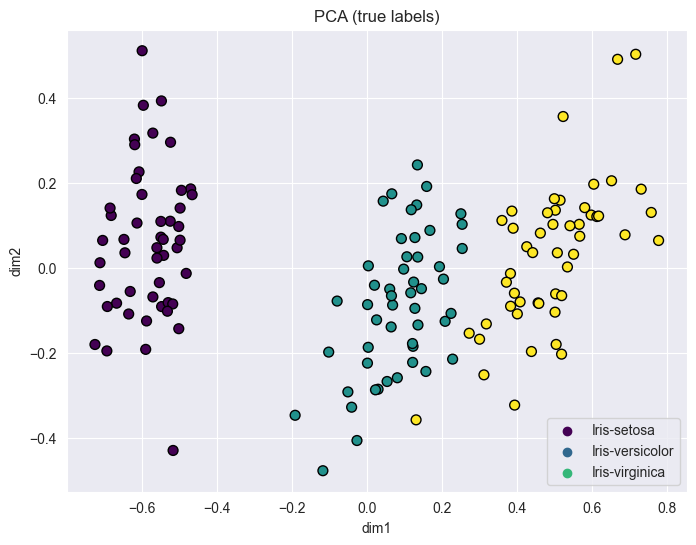

PCA: predicted labels (model)


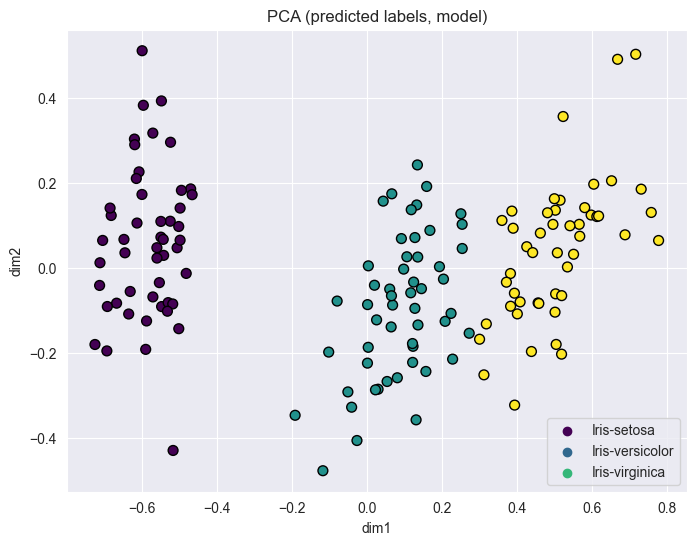

t-SNE: true labels


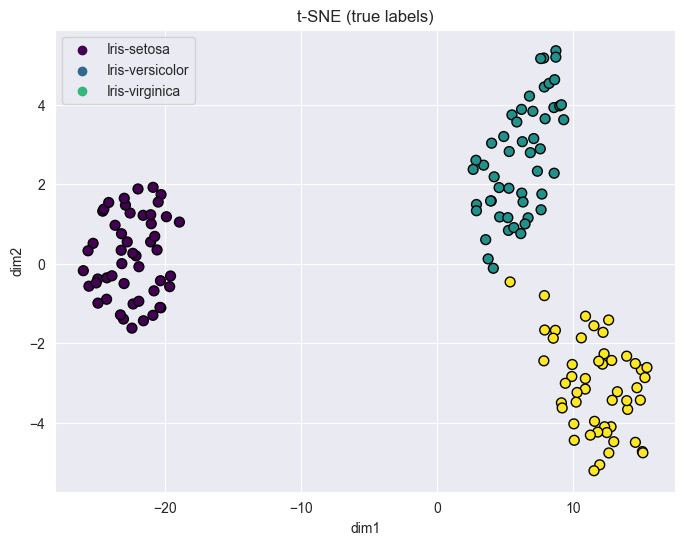

t-SNE: predicted labels (model)


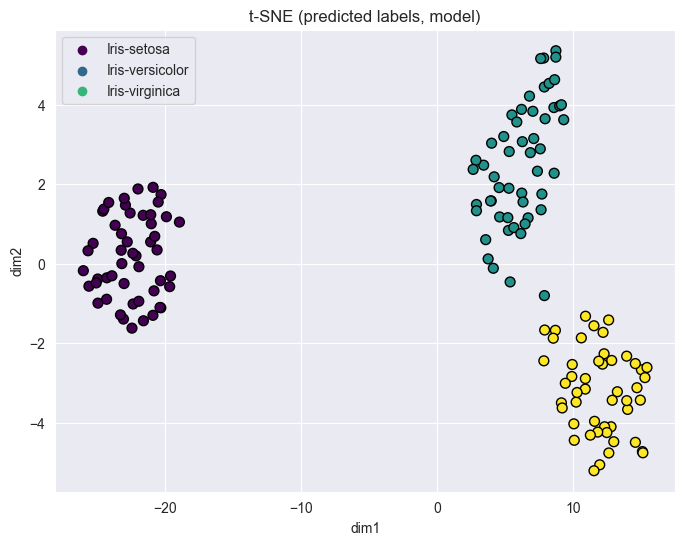

In [158]:
X_full = X_norm  # используем нормализованные признаки для DR

# 1) PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full)

# 2) t-SNE (некоторые реализации могут быть медленны, но для Iris это ок)
tsne = TSNE(n_components=2, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_full)

# Предсказания по всей выборке с model (обучена на нормализованных данных)
pred_full = model.predict(X_full)

# Функция для отрисовки
def plot_embeddings(emb, title, labels_numeric):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb[:,0], emb[:,1], c=labels_numeric, cmap='viridis', s=50, edgecolor='k')
    plt.title(title)
    # легенда по цвету
    for i, cls in enumerate(classes):
        plt.scatter([], [], color=plt.cm.viridis(i/len(classes)), label=cls)
    plt.legend()
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.grid(True)
    plt.show()

label_true_num = y_num
label_pred_num = pred_full

print('PCA: true labels')
plot_embeddings(X_pca, 'PCA (true labels)', label_true_num)
print('PCA: predicted labels (model)')
plot_embeddings(X_pca, 'PCA (predicted labels, model)', label_pred_num)

print('t-SNE: true labels')
plot_embeddings(X_tsne, 't-SNE (true labels)', label_true_num)
print('t-SNE: predicted labels (model)')
plot_embeddings(X_tsne, 't-SNE (predicted labels, model)', label_pred_num)